In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def color_transform(image, to_color = 'RGB'):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image) 
    return feature_image        
            
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features


    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [32]:
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as pyplot

%matplotlib inline

base_path = "train"
# Read in cars and notcars
car_dirs = ["/vehicles/KITTI_extracted/*.png",
            "/vehicles/GTI_Far/*.png",
            "/vehicles/GTI_Right/*.png",
            "/vehicles/GTI_MiddleClose/*.png",
           "/vehicles/GTI_Left/*.png"]

nocar_dirs = ["/non-vehicles/Extras/*.png",
             "/non-vehicles/GTI/*.png"]

car_image_paths = []
nocar_image_paths = []

for glob_path in car_dirs:
    print(base_path + glob_path)
    car_image_paths += glob.glob(base_path + glob_path)

for glob_path in nocar_dirs:
    nocar_image_paths += glob.glob(base_path + glob_path)
    
print("# Car paths: ", len(car_image_paths))

print("# of  No-car paths: ", len(nocar_image_paths))
    
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = car_image_paths[0:sample_size]
notcars = nocar_image_paths[0:sample_size]

cars = car_image_paths
notcars = nocar_image_paths
### YCrCb color space works the best for detecting cars on a multi-lane road !!
###
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

model_pickle_file = "svc_pickle_full_16_2_only_hog.p"
#model_pickle_file = "svc_pickle_full_32.p"

def save_pickle(svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    pickle.dump(dist_pickle, open(model_pickle_file, "wb"))

    
def load_pickle():
    dist_pickle = pickle.load( open(model_pickle_file, "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    return svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins


print("Saving model...")
save_pickle(svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

train/vehicles/KITTI_extracted/*.png
train/vehicles/GTI_Far/*.png
train/vehicles/GTI_Right/*.png
train/vehicles/GTI_MiddleClose/*.png
train/vehicles/GTI_Left/*.png
# Car paths:  8792
# of  No-car paths:  8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
14.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
Saving model...


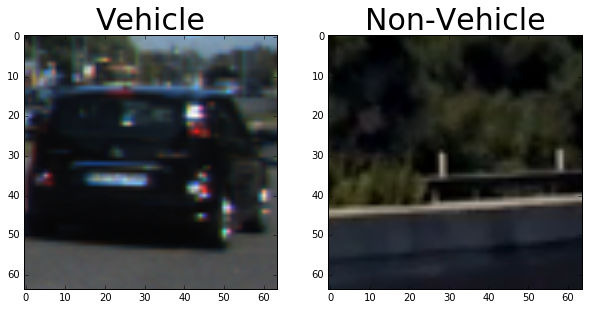

In [55]:


# Helper routine just for visualization purposes.
def hog_viz(hog_channel, orient, pix_per_cell, cell_per_block, image_file):
    image = mpimg.imread(image_file)
    feature_image = color_transform(image, 'YCrCb')
    hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                    pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    return hog_features, hog_image, feature_image[:,:,hog_channel]

f, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(10,20))

sample_car1 = cars[0]
sample_nocar1 = notcars[0]

ax1.imshow(mpimg.imread(sample_car1))
ax1.set_title("Vehicle", fontsize=30)

ax2.imshow(mpimg.imread(sample_nocar1))
ax2.set_title("Non-Vehicle", fontsize=30)
pyplot.savefig('output_images/car_nocar_eg.png')



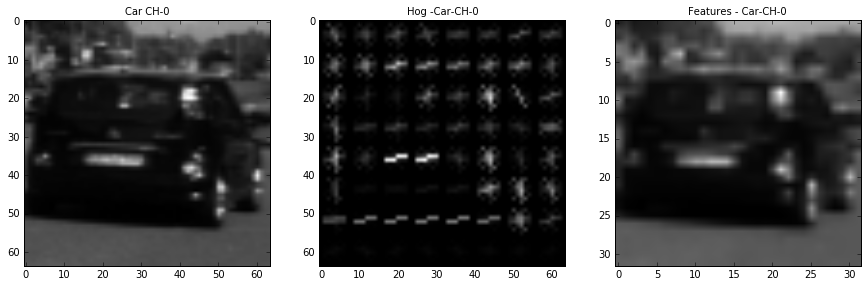

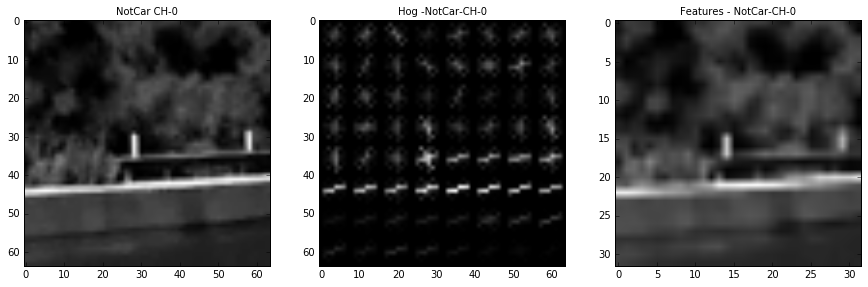

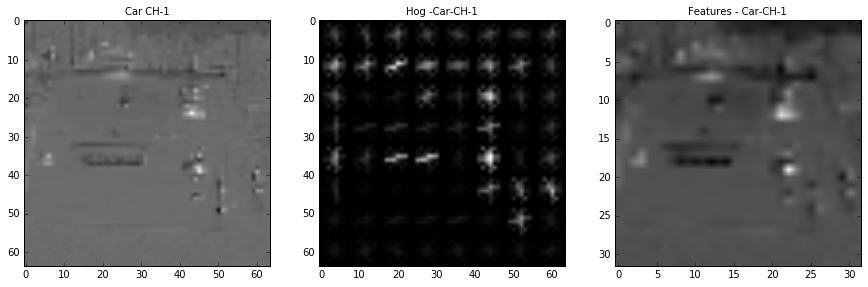

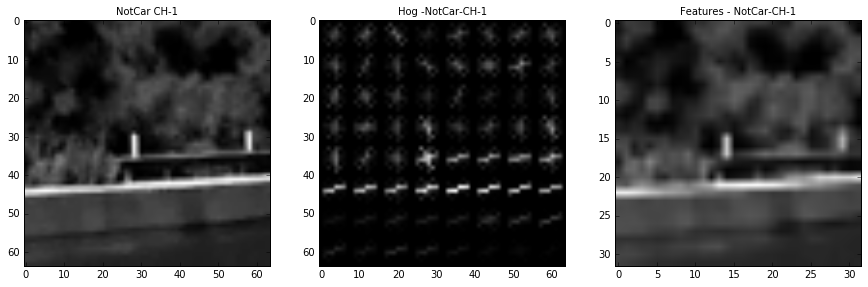

In [63]:
def plot_3(image1, title1, image2, title2, image3, title3, outfile):
    f, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(15,30))
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(title1, fontsize=10)

    ax2.imshow(image2, cmap='gray')
    ax2.set_title(title2, fontsize=10)
    
    ax3.imshow(image3, cmap='gray')
    ax3.set_title(title3, fontsize=10)
    pyplot.savefig(outfile)
    
hog_ch = 0
hog_features, hog_image, hog_ch = hog_viz(0, orient, pix_per_cell, cell_per_block, sample_car1)

plot_3(hog_ch, "Car CH-0", hog_image, "Hog -Car-CH-0", cv2.resize(hog_ch, (32, 32)), "Features - Car-CH-0", "output_images/hog1.png")

hog_features, hog_image, hog_ch = hog_viz(0, orient, pix_per_cell, cell_per_block, sample_nocar1)

plot_3(hog_ch, "NotCar CH-0", hog_image, "Hog -NotCar-CH-0", cv2.resize(hog_ch, (32, 32)), "Features - NotCar-CH-0", "output_images/hog2.png")

hog_features, hog_image, hog_ch = hog_viz(1, orient, pix_per_cell, cell_per_block, sample_car1)

plot_3(hog_ch, "Car CH-1", hog_image, "Hog -Car-CH-1", cv2.resize(hog_ch, (32, 32)), "Features - Car-CH-1", "output_images/hog3.png")

hog_features, hog_image, hog_ch = hog_viz(0, orient, pix_per_cell, cell_per_block, sample_nocar1)

plot_3(hog_ch, "NotCar CH-1", hog_image, "Hog -NotCar-CH-1", cv2.resize(hog_ch, (32, 32)), "Features - NotCar-CH-1", "output_images/hog4.png")


#pyplot.savefig('output_images/car_nocar_eg.png')


#pyplot.savefig('output_images/car_nocar_eg.png')


Using xy_window (256, 256) and y_start_stop [380, None]
Using xy_window (192, 192) and y_start_stop [380, None]
Using xy_window (128, 128) and y_start_stop [380, None]
Using xy_window (96, 96) and y_start_stop [380, None]
Using xy_window (64, 64) and y_start_stop [380, 620]
Number of windows = 493


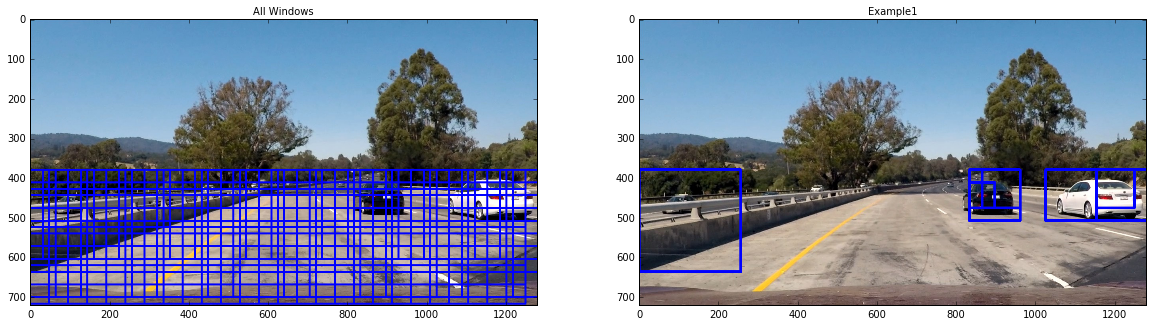

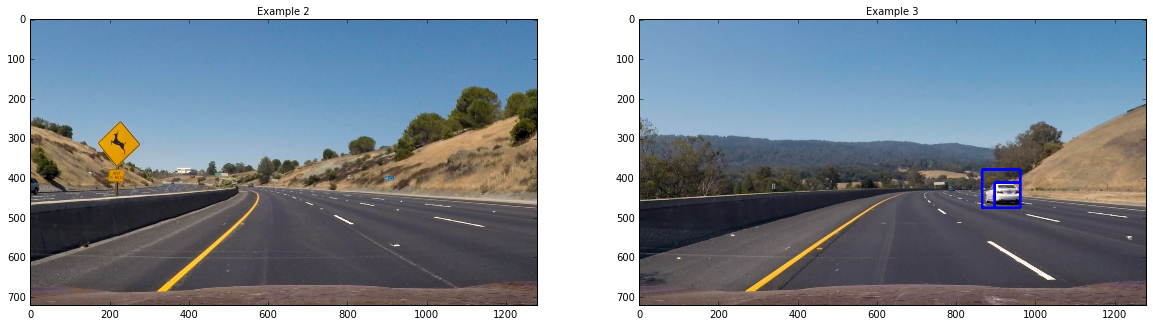

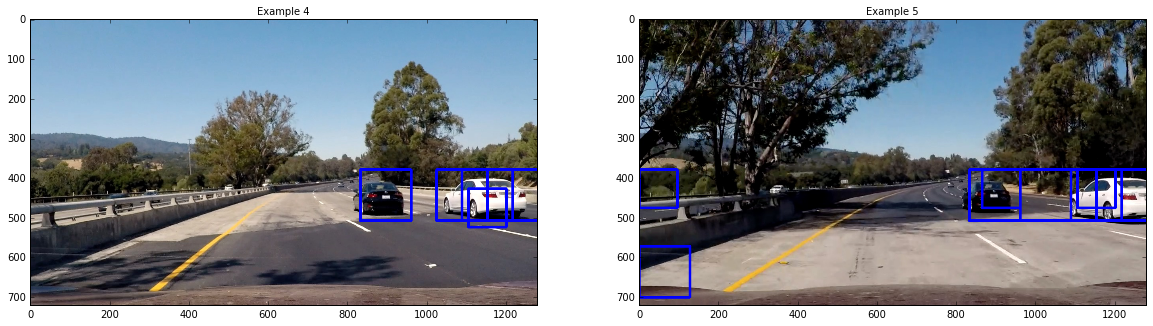

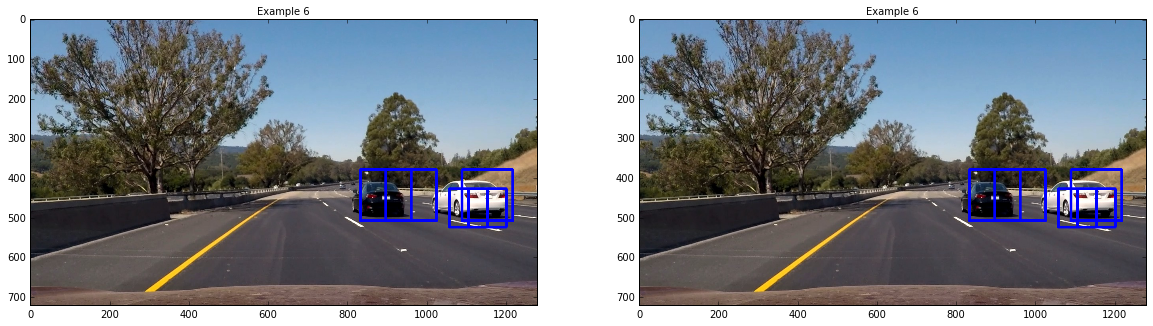

In [50]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
test_image = 'test_images/test1.jpg'

image = mpimg.imread(test_image)
draw_image = np.copy(image)
just_windows = np.copy(image)

model_pickle_file = "svc_pickle_full_16_2_only_hog.p"
svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins = load_pickle()
y_start_stop = [340, None] # Min and max in y to search in slide_window()

# Values of y start/stop and corresponding window sizes for multi-scale search
# format = list of tuples where each tuple:
# ( xy_window, y_start_stop))
multi_scale_params = [  ( (256, 256), [380, None], (0.5, 0.5)),
                      ( (192, 192), [380, None], (0.5, 0.5)), 
                      ( (128, 128), [380, None], (0.5, 0.5)),
                      ( (96, 96), [380, None], (0.5, 0.5)),
                      ( (64, 64), [380, 620], (0.5, 0.5)),
                       ]

def get_multi_scale_windows(image, multi_scale_params):
    g_windows = []
    for param in multi_scale_params:
        g_xy_window = param[0]
        g_y_start_stop = param[1]
        xy_overlap = param[2]
        print("Using xy_window {} and y_start_stop {}".format(g_xy_window, g_y_start_stop))
        g_windows += slide_window(image, x_start_stop=[None, None], y_start_stop=g_y_start_stop, 
                                  xy_window=g_xy_window, xy_overlap=xy_overlap)
    return g_windows


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

windows = get_multi_scale_windows(image, multi_scale_params)
print("Number of windows = {}".format(len(windows)))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

just_windows = draw_boxes(draw_image, windows,  color=(0, 0, 255), thick=3)


def single_image_search(filename):
    s_image = mpimg.imread(filename)
    s_draw_image = np.copy(s_image)
    s_image = s_image.astype(np.float32)/255
    s_hot_windows = search_windows(s_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    s_window_img = draw_boxes(s_draw_image, s_hot_windows, color=(0, 0, 255), thick=6)    
    return s_window_img

def plot_2(image1, title1, image2, title2, outfile):
    f, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(20,40))
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(title1, fontsize=10)

    ax2.imshow(image2, cmap='gray')
    ax2.set_title(title2, fontsize=10)
    pyplot.savefig(outfile)

plot_2(just_windows, "All Windows", window_img, "Example1", "d/output_images/sliding_window1.png")

test2 = single_image_search("test_images/test2.jpg")
test3 = single_image_search("test_images/test3.jpg")
plot_2(test2, "Example 2", test3, "Example 3", "d/output_images/sliding_window_2.png")

test4 = single_image_search("test_images/test4.jpg")
test5 = single_image_search("test_images/test5.jpg")
plot_2(test4, "Example 4", test5, "Example 5", "d/output_images/sliding_window_3.png")

test6 = single_image_search("test_images/test6.jpg")
plot_2(test6, "Example 6", test6, "Example 6", "d/output_images/sliding_window_4.png")

#pyplot.imshow(window_img)

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features_fg(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial_fg(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist_fg(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_fast_hog(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features_fg(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features_fg(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features_fg(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    result_bbox = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial_fg(subimg, size=spatial_size)
            hist_features = color_hist_fg(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features.ravel(), hist_features.ravel(), hog_features.ravel())).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                result_bbox.append( (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                
    return result_bbox

def single_image_search_fast_hog(s_image, multi_scale_params):
    s_draw_image = np.copy(s_image)
    #s_image = s_image.astype(np.float32)/255
    bboxes = []
    for param in multi_scale_params:
        g_xy_window = param[0]
        g_y_start_stop = param[1]
        ystart = g_y_start_stop[0]
        ystop = g_y_start_stop[1]
        scale = 1.0
        bboxes += find_cars_fast_hog(s_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    s_window_img = draw_boxes(s_draw_image, bboxes, color=(0, 0, 255), thick=6) 
    return s_window_img

test_image = 'test_images/test1.jpg'

image = mpimg.imread(test_image)

ystart = 380
ystop = 700
scale = 2.0
#find_cars_fast_hog(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

In [8]:
#heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
import math


class CarTraker:
    def __init__(self):
        self.detected = False
        
        # List of bounding boxes that represent a car.
        self.car_bboxes = []
        
    def add_heatmap(self, heatmap):
        apply_threshold(heatmap, 2)
        labels = label(heatmap)
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
old_heat_vector = []

model_pickle_file = "svc_pickle_full_16_2_only_hog.p"
svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins = load_pickle()
y_start_stop = [350, None] # Min and max in y to search in slide_window()

windows = get_multi_scale_windows(image, multi_scale_params)


def combine_heatmap(ohv, new_heatmap):
    old_heat = ohv[-5:]
    nh = np.copy(new_heatmap* 2)
    for heatmap in old_heat:
        nh += heatmap
        
    ohv.append(new_heatmap)
    return ohv[-5:], nh

debug_run = True
debug_ctr = 0

multi_scale_params2 = [( (96, 96), [400, 600], (0.8, 0.8)),
                      ( (64, 64), [400, 620], (0.75, 0.75)),
                       ]

def get_multi_scale_windows2(image, multi_scale_params, x_start_stop):
    g_windows = []
    for param in multi_scale_params:
        g_xy_window = param[0]
        g_y_start_stop = param[1]
        xy_overlap = param[2]
        print("Using xy_window {} and y_start_stop {}".format(g_xy_window, g_y_start_stop))
        g_windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=g_y_start_stop, 
                                  xy_window=g_xy_window, xy_overlap=xy_overlap)
    return g_windows

additional_windows = get_multi_scale_windows2(image, multi_scale_params2, [700, 1280])

windows = additional_windows
print("Number of windows = {}".format(len(windows)))

def process_image(p_input_image):
    global old_heat_vector, debug_run, debug_ctr
    s_image = p_input_image.astype(np.float32)/255
    s_hot_windows = search_windows(s_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
    heat = np.zeros_like(s_image[:,:,0]).astype(np.float)
    s_draw_image = np.copy(p_input_image)
    add_heat(heat, s_hot_windows)
    apply_threshold(heat, 2)
    #old_heat_vector, combined_heat = combine_heatmap(old_heat_vector, heat)
    #apply_threshold(combined_heat, 2)
    labels = label(heat)
    output_image = draw_labeled_bboxes(s_draw_image, labels)
    #output_image = draw_boxes(s_draw_image, s_hot_windows, color=(0, 0, 255), thick=6)   
    if debug_run:
        cv2.imwrite("output_images/frame_{}.jpg".format(debug_ctr), cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite("output_images/heat_{}.jpg".format(debug_ctr), heat*128)
        cv2.imwrite("output_images/label_{}.jpg".format(debug_ctr), combined_heat*128)
        debug_ctr += 1
    return output_image

def process_image_fast_hog(p_input_image):
    output_image = single_image_search_fast_hog(p_input_image, multi_scale_params)
    return output_image

#process_image(image)

#project_output = 'project_out_2.mp4'
project_output = 'project_out_3.mp4'

#clip1 = VideoFileClip("test_video.mp4")

i = 0
initial_frames = []
#for frame in clip1.iter_frames():
#    if (i > 10):
#          break
#    else:
#        process_image(frame)
#    i += 1
clip1 = VideoFileClip("project_video.mp4")
debug_run = False
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(project_output, audio=False)

Using xy_window (256, 256) and y_start_stop [380, 720]
Using xy_window (192, 192) and y_start_stop [380, 720]
Using xy_window (128, 128) and y_start_stop [380, 720]
Using xy_window (96, 96) and y_start_stop [380, 720]
Using xy_window (64, 64) and y_start_stop [380, 620]
Using xy_window (96, 96) and y_start_stop [400, 600]
Using xy_window (64, 64) and y_start_stop [400, 620]
Number of windows = 486
[MoviePy] >>>> Building video project_out_3.mp4
[MoviePy] Writing video project_out_3.mp4


  6%|▋         | 80/1261 [02:26<36:41,  1.86s/it]

In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))